# NMCの実行

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from l96 import gen_l96, rk4
from letkf import LETKF

In [2]:
# Lorenz96の設定
J = 40
F = 8
lorenz = gen_l96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(lorenz, 0, x, 0.01)
    return x

# 単位行列
I = np.eye(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r = 1.0
R = r*I

# 観測値と真値
end_step = 500 # 開発用
x_true = np.load('../data/x_true.npy')
y = np.load('../data/x_obs.npy')
if not np.isclose(r, 1.0):
    y = x_true + np.random.normal(loc=0, scale=r, size=x_true.shape) # R = r*I

# KFの初期値
# seed = 1
# np.random.seed(seed)
# x_0 = x_true[np.random.randint(len(x_true)-1)]

In [3]:
P_0 = 25*I

def assim(seed):
    np.random.seed(seed)
    x_0 = x_true[np.random.randint(len(x_true)-1)]
    letkf = LETKF(M, H, R, x_0, P_0, m=20, alpha=1.03, seed=seed,
                c=11.0, localization='gaspari-cohn', addaptive=False, multi_process=False)
    for y_obs in tqdm(y):
        letkf.forecast(dt)
        letkf.update(y_obs)

    return letkf.x

In [4]:
print(f"n_step: {len(x_true)}, dt: {dt}")

n_step: 1440, dt: 0.05


In [5]:
dt1 = 0.1 # 12hに対応
dt2 = 0.3 # 36hに対応

n_step1 = round(dt1/dt)
n_step2 = round(dt2/dt)
# print(n_step1, n_step2)

def nmc(seed):
    x_assim = assim(seed)
    E = []
    for n in tqdm(range(n_step2, len(x_assim), n_step1)):
        x1 = M(x_assim[n-n_step1], dt1)
        x2 = M(x_assim[n-n_step2], dt2)
        E.append(x2-x1)
    E = np.array(E)

    B = E.T@E
    B /= np.abs(B).max()
    return B

def plot_B(B):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    im = axes[0].imshow(B, origin="lower")
    plt.colorbar(im)
    axes[1].plot([B[n,n] for n in range(B.shape[0])])

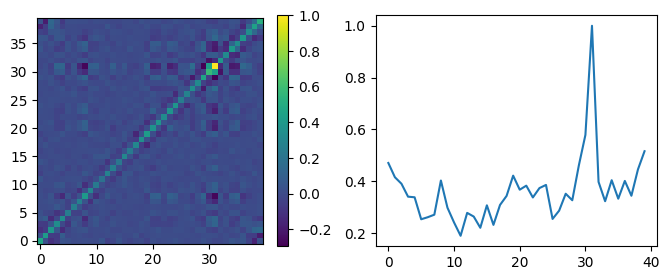

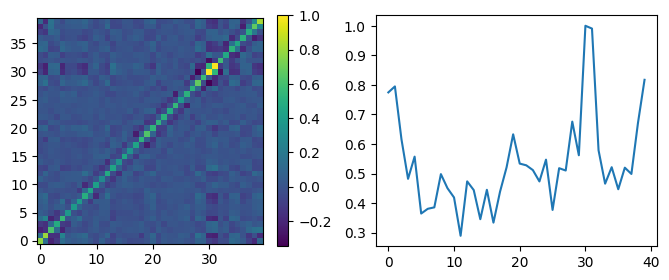

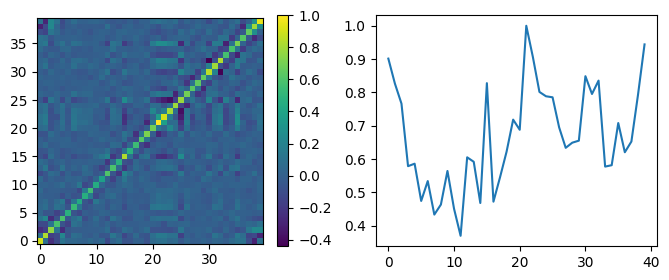

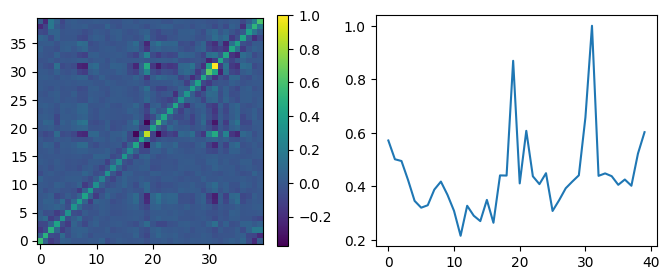

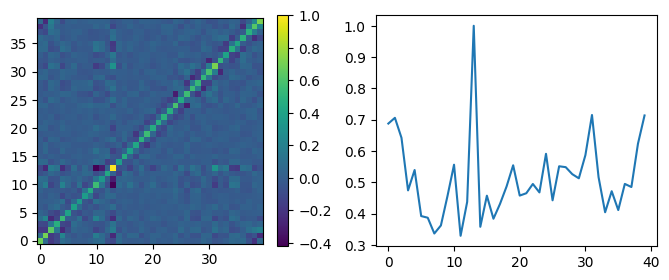

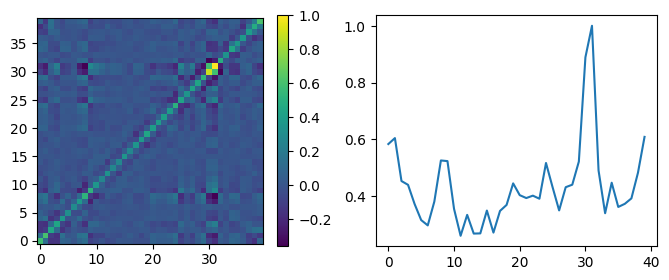

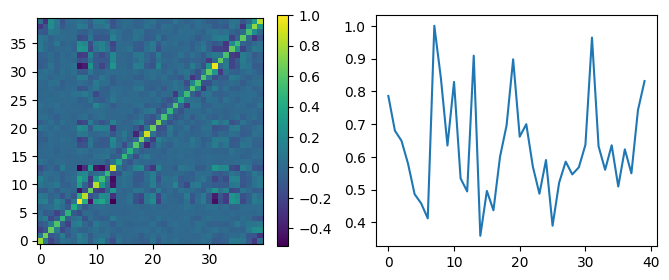

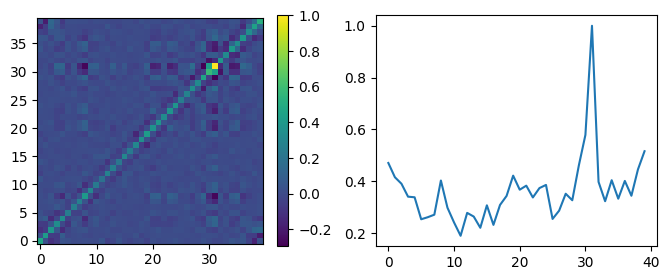

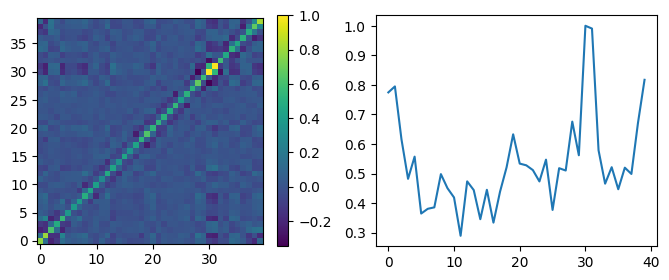

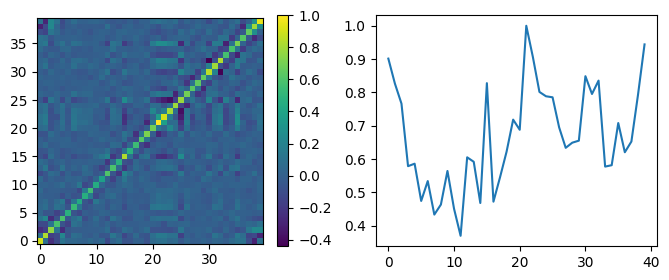

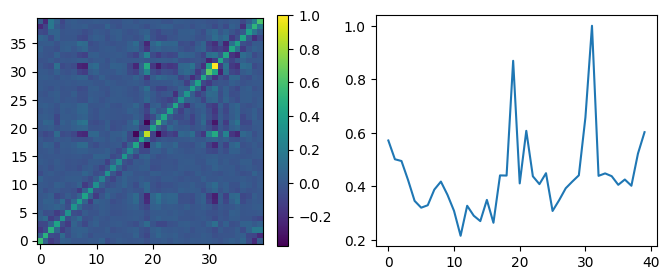

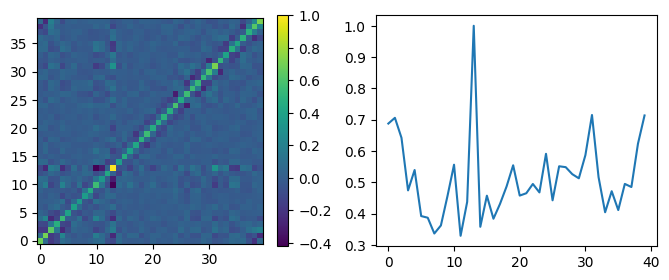

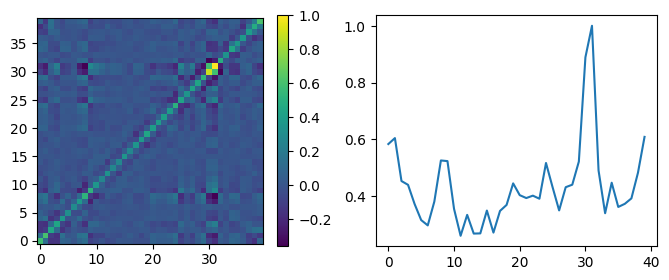

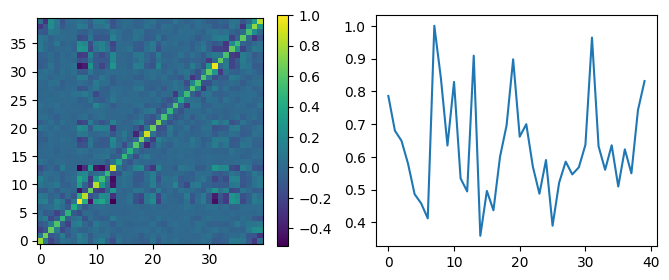

In [8]:
from optimize import exec_mp
seeds = [1, 2, 3, 4, 5, 6, 7]

Bs = []
seeds_to_compute = []
for seed in seeds:
    try:
        B = np.load(f"../data/B{seed}.npy")
        Bs.append(B)
        plot_B(B)
    except:
        seeds_to_compute.append(seed)
        
for seed, B in zip(seeds_to_compute, exec_mp(nmc, seeds_to_compute, n_process=10)):
    np.save(f"../data/B{seed}.npy", B)
    Bs.append(B)
    
for B in Bs:
    plot_B(B)    

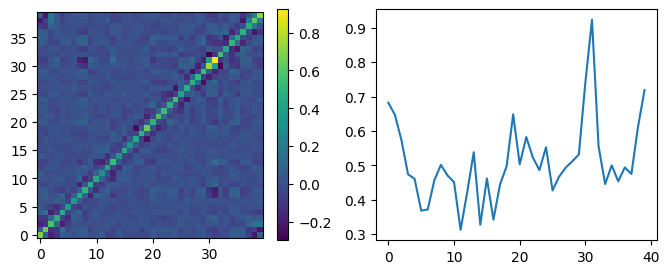

In [10]:
B_mean = np.array(Bs).mean(axis=0)
np.save("../data/B_mean.npy", B_mean)
plot_B(B_mean)